In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

In [69]:
# Simulation Parameters
t0, tf, dt = 0.0, 30.0, 0.1              # start time, end time, time step
time = np.arange(t0, tf + dt, dt)       # time array
n_steps = len(time)

### Initial Troop Strengths


In [70]:
# For Square Law (Regular warfare) and Linear Law (Irregular warfare)
R0_sq, B0_sq = 1000.0, 800.0
R0_lin, B0_lin = 1000.0, 800.0

# For Multilateral Model
R0_m, B0_m, G0_m = 1000.0, 800.0, 600.0

#### Attrition Parameters

In [71]:
# Square Law (Regular)
a_rb_sq = 0.0002    # Blue's effectiveness on Red (square law)
b_rb_sq = 0.0001    # Red's effectiveness on Blue (square law)

# Linear Law (Irregular)
a_rb_lin = 0.0001   # Blue's constant attrition on Red (linear law)
b_rb_lin = 0.0001   # Red's constant attrition on Blue (linear law)

# Multilateral (Combined)
a_rb_m   = 0.0002   # Blue's square-law on Red
b_rb_m   = 0.0001   # Red's square-law on Blue
a_gl_m   = 0.0003   # Green's linear attrition on Blue
b_gl_m   = 0.00015  # Blue's linear attrition on Green
k_rg_m   = 0.0001   # Green's effect on Red
k_gr_m   = 0.00005  # Red's effect on Green

#### Preallocate Arrays

In [72]:
R_sq   = np.zeros(n_steps); B_sq   = np.zeros(n_steps)
R_lin  = np.zeros(n_steps); B_lin  = np.zeros(n_steps)
R_m    = np.zeros(n_steps); B_m    = np.zeros(n_steps); G_m = np.zeros(n_steps)

# Initialize
R_sq[0], B_sq[0]         = R0_sq, B0_sq
R_lin[0], B_lin[0]       = R0_lin, B0_lin
R_m[0], B_m[0], G_m[0]   = R0_m, B0_m, G0_m

### Compute Dynamics (Before Animating)


In [73]:
for i in range(1, n_steps):
    # Previous values
    r_sq_prev, b_sq_prev     = R_sq[i-1], B_sq[i-1]
    r_lin_prev, b_lin_prev   = R_lin[i-1], B_lin[i-1]
    r_m_prev, b_m_prev, g_m_prev = R_m[i-1], B_m[i-1], G_m[i-1]

    # --- Square Law (Regular) ---
    dR_sq = -a_rb_sq * (b_sq_prev**2)
    dB_sq = -b_rb_sq * (r_sq_prev**2)
    R_sq[i] = max(r_sq_prev + dR_sq * dt, 0.0)
    B_sq[i] = max(b_sq_prev + dB_sq * dt, 0.0)

    # --- Linear Law (Irregular) ---
    dR_lin = -a_rb_lin
    dB_lin = -b_rb_lin
    R_lin[i] = max(r_lin_prev + dR_lin * dt, 0.0)
    B_lin[i] = max(b_lin_prev + dB_lin * dt, 0.0)

    # --- Multilateral Model ---
    dR_m_sq  = -a_rb_m   * (b_m_prev**2)
    dB_m_sq  = -b_rb_m   * (r_m_prev**2)
    dG_m_lin = -b_gl_m   * b_m_prev
    dB_m_lin = -a_gl_m   * g_m_prev
    dR_m_inf = -k_rg_m   * g_m_prev
    dG_m_inf = -k_gr_m   * r_m_prev

    dR_m_total = dR_m_sq + dR_m_inf
    dB_m_total = dB_m_sq + dB_m_lin
    dG_m_total = dG_m_lin + dG_m_inf

    R_m[i] = max(r_m_prev + dR_m_total * dt, 0.0)
    B_m[i] = max(b_m_prev + dB_m_total * dt, 0.0)
    G_m[i] = max(g_m_prev + dG_m_total * dt, 0.0)

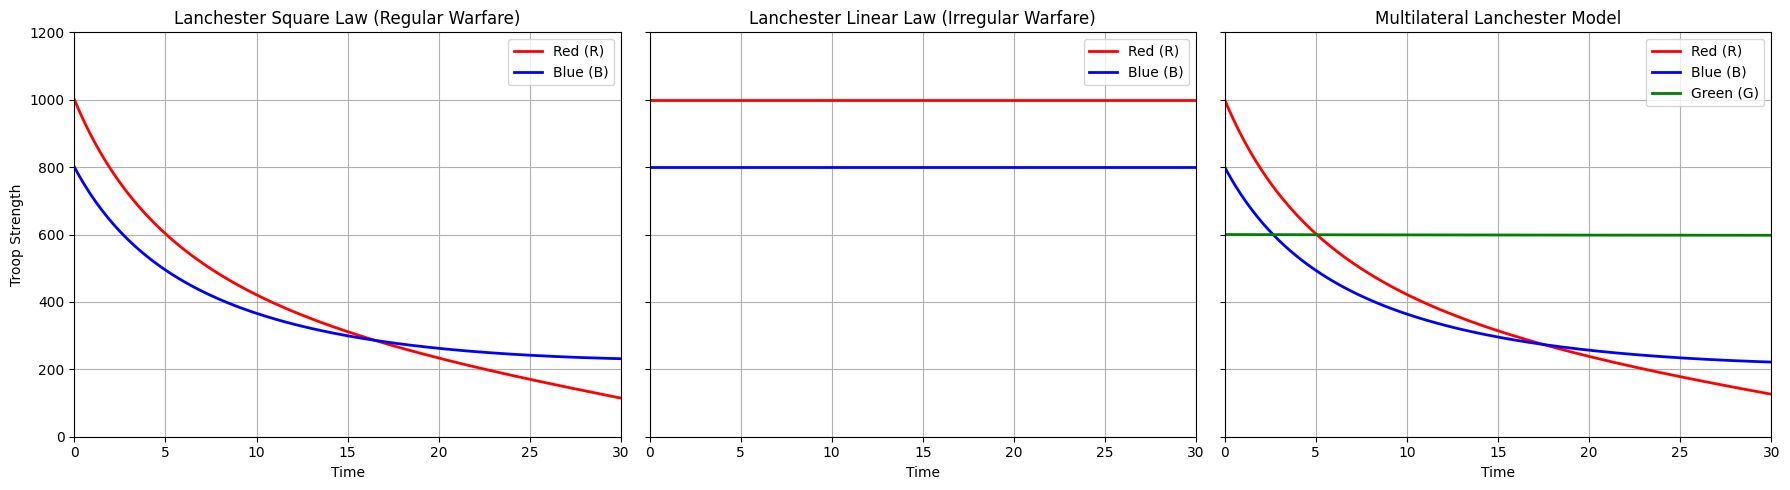

In [74]:
# STATIC PLOT: Show Full Time‐Series Curves Immediately
fig_static, axs_static = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Square Law subplot
axs_static[0].plot(time, R_sq, 'r-', lw=2, label='Red (R)')
axs_static[0].plot(time, B_sq, 'b-', lw=2, label='Blue (B)')
axs_static[0].set_title("Lanchester Square Law (Regular Warfare)")
axs_static[0].set_xlabel("Time"); axs_static[0].set_ylabel("Troop Strength")
axs_static[0].set_xlim(t0, tf); axs_static[0].set_ylim(0, max(R0_sq, B0_sq)*1.2)
axs_static[0].legend(); axs_static[0].grid(True)

# Linear Law subplot
axs_static[1].plot(time, R_lin, 'r-', lw=2, label='Red (R)')
axs_static[1].plot(time, B_lin, 'b-', lw=2, label='Blue (B)')
axs_static[1].set_title("Lanchester Linear Law (Irregular Warfare)")
axs_static[1].set_xlabel("Time")
axs_static[1].set_xlim(t0, tf); axs_static[1].set_ylim(0, max(R0_lin, B0_lin)*1.2)
axs_static[1].legend(); axs_static[1].grid(True)

# Multilateral subplot
axs_static[2].plot(time, R_m, 'r-', lw=2, label='Red (R)')
axs_static[2].plot(time, B_m, 'b-', lw=2, label='Blue (B)')
axs_static[2].plot(time, G_m, 'g-', lw=2, label='Green (G)')
axs_static[2].set_title("Multilateral Lanchester Model")
axs_static[2].set_xlabel("Time")
axs_static[2].set_xlim(t0, tf); axs_static[2].set_ylim(0, max(R0_m, B0_m, G0_m)*1.2)
axs_static[2].legend(); axs_static[2].grid(True)

plt.tight_layout()
plt.show()

#### Set Up Plot (3 Subplots: Square, Linear, Multilateral)

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Square Law subplot
axs[0].set_title("Lanchester Square Law (Regular)")
axs[0].set_xlabel("Time"); axs[0].set_ylabel("Troop Strength")
axs[0].set_xlim(t0, tf); axs[0].set_ylim(0, max(R0_sq, B0_sq) * 1.2)
line_r_sq, = axs[0].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_sq, = axs[0].plot([], [], 'b-', lw=2, label='Blue (B)')
axs[0].legend(); axs[0].grid(True)

# Linear Law subplot
axs[1].set_title("Lanchester Linear Law (Irregular)")
axs[1].set_xlabel("Time")
axs[1].set_xlim(t0, tf); axs[1].set_ylim(0, max(R0_lin, B0_lin) * 1.2)
line_r_lin, = axs[1].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_lin, = axs[1].plot([], [], 'b-', lw=2, label='Blue (B)')
axs[1].legend(); axs[1].grid(True)

# Multilateral subplot
axs[2].set_title("Multilateral Lanchester Model")
axs[2].set_xlabel("Time")
axs[2].set_xlim(t0, tf); axs[2].set_ylim(0, max(R0_m, B0_m, G0_m) * 1.2)
line_r_m, = axs[2].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_m, = axs[2].plot([], [], 'b-', lw=2, label='Blue (B)')
line_g_m, = axs[2].plot([], [], 'g-', lw=2, label='Green (G)')
axs[2].legend(); axs[2].grid(True)

### Animation Function

In [76]:
def animate(frame):
    # Update Square Law curves
    line_r_sq.set_data(time[:frame], R_sq[:frame])
    line_b_sq.set_data(time[:frame], B_sq[:frame])

    # Update Linear Law curves
    line_r_lin.set_data(time[:frame], R_lin[:frame])
    line_b_lin.set_data(time[:frame], B_lin[:frame])

    # Update Multilateral curves
    line_r_m.set_data(time[:frame], R_m[:frame])
    line_b_m.set_data(time[:frame], B_m[:frame])
    line_g_m.set_data(time[:frame], G_m[:frame])

    return (line_r_sq, line_b_sq,
            line_r_lin, line_b_lin,
            line_r_m, line_b_m, line_g_m)

In [77]:
### Create the Animation

In [78]:
fig_anim, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

#Prepare empty lines on each subplot
line_r_sq, = axs[0].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_sq, = axs[0].plot([], [], 'b-', lw=2, label='Blue (B)')
axs[0].set_title("Lanchester Square Law (Regular Warfare)")
axs[0].set_xlabel("Time"); axs[0].set_ylabel("Troop Strength")
axs[0].set_xlim(t0, tf); axs[0].set_ylim(0, max(R0_sq, B0_sq)*1.2)
axs[0].legend(); axs[0].grid(True)
line_r_lin, = axs[1].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_lin, = axs[1].plot([], [], 'b-', lw=2, label='Blue (B)')
axs[1].set_title("Lanchester Linear Law (Irregular Warfare)")
axs[1].set_xlabel("Time")
axs[1].set_xlim(t0, tf); axs[1].set_ylim(0, max(R0_lin, B0_lin)*1.2)
axs[1].legend(); axs[1].grid(True)
line_r_m, = axs[2].plot([], [], 'r-', lw=2, label='Red (R)')
line_b_m, = axs[2].plot([], [], 'b-', lw=2, label='Blue (B)')
line_g_m, = axs[2].plot([], [], 'g-', lw=2, label='Green (G)')
axs[2].set_title("Multilateral Lanchester Model")
axs[2].set_xlabel("Time")
axs[2].set_xlim(t0, tf); axs[2].set_ylim(0, max(R0_m, B0_m, G0_m)*1.2)
axs[2].legend(); axs[2].grid(True)

In [79]:
def animate(frame):
     # Update Square Law curves
    line_r_sq.set_data(time[:frame], R_sq[:frame])
    line_b_sq.set_data(time[:frame], B_sq[:frame])

     # Update Linear Law curves
    line_r_lin.set_data(time[:frame], R_lin[:frame])
    line_b_lin.set_data(time[:frame], B_lin[:frame])

     # Update Multilateral curves
    line_r_m.set_data(time[:frame], R_m[:frame])
    line_b_m.set_data(time[:frame], B_m[:frame])
    line_g_m.set_data(time[:frame], G_m[:frame])

    return (line_r_sq, line_b_sq,
            line_r_lin, line_b_lin,
            line_r_m, line_b_m, line_g_m)

In [80]:
ani = FuncAnimation(fig_anim, animate, frames=n_steps, interval=int(dt*1000), blit=True)


In [ ]:
try:
    mp4_writer = FFMpegWriter(fps=30, metadata={"artist": "Matplotlib"}, bitrate=1800)
    ani.save("battle_simulation.mp4", writer=mp4_writer)
    print("Saved battle_simulation.mp4")
except (FileNotFoundError, RuntimeError):
    print("FFmpeg not found. Skipping MP4 export.If FFmpeg is installed and on your PATH, also a file named battle_simulation.mp4. Otherwise you’ll see “Skipping MP4 export.”")

FFmpeg not found. Skipping MP4 export.


In [82]:
 # Always save GIF
gif_writer = PillowWriter(fps=30)
ani.save("battle_simulation.gif", writer=gif_writer)
print("Saved battle_simulation.gif")

Saved battle_simulation.gif


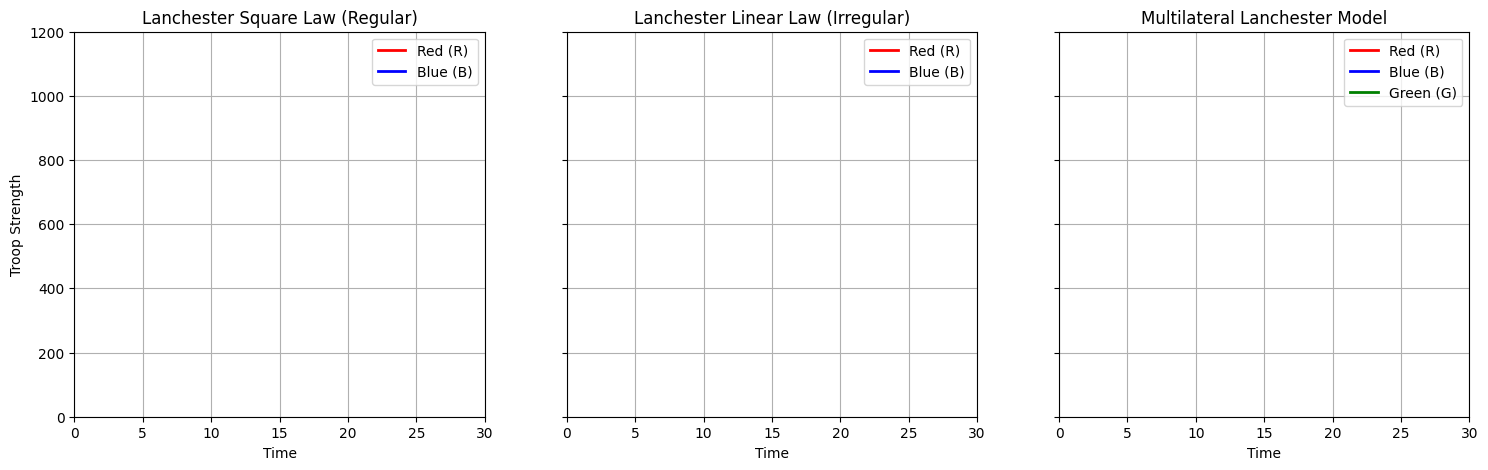

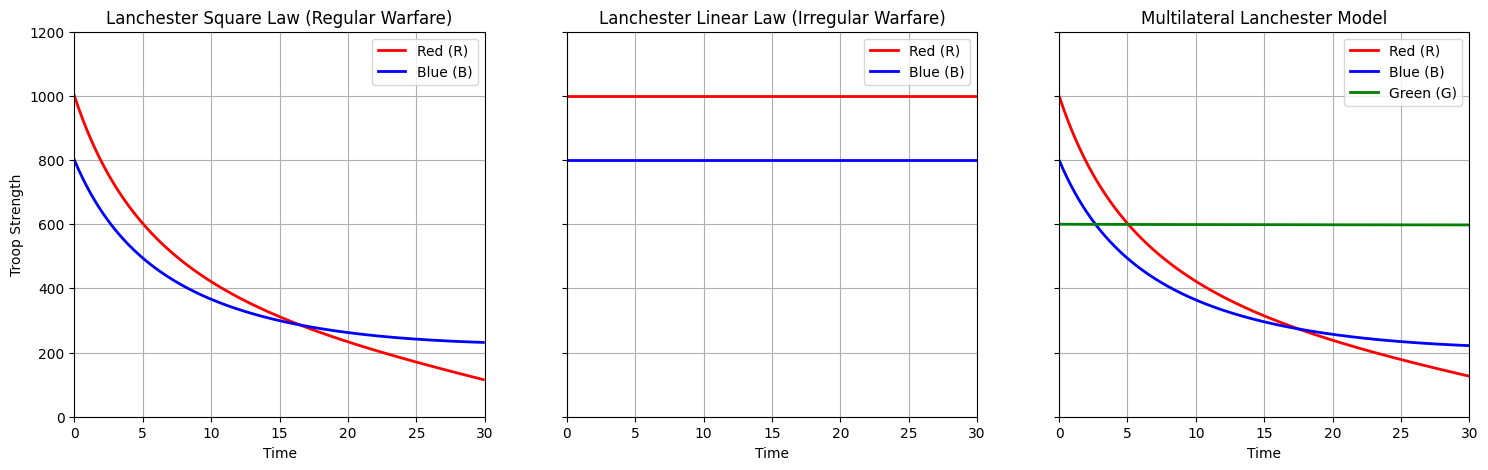

In [83]:
plt.show()